In [ ]:
from __future__ import print_function,division

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy

plt.ion()  #interactive mode

In [ ]:
from zipfile import ZipFile

with ZipFile("hymenoptera_data.zip","r") as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
#Data augmentation and normalizing for training
# Just normalization for the validation set

data_transforms = {
    "train" : transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    "val" : transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

data_dir = "/content/hymenoptera_data"


In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                          data_transforms[x]) 
                                            for x in ["train","val"]}

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle = True,num_workers = 4)
                            for x in ["train","val"]}


In [ ]:
len(dataloaders)

2

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train","val"]}
class_names = image_datasets["train"].classes

In [ ]:
class_names

['ants', 'bees']

In [ ]:
# Use pretrained model (RESNET-18)

model =models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad=False

classifier = nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,2))
model.fc = classifier

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

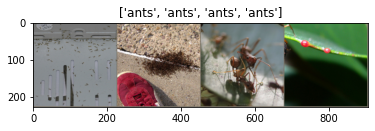

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
len(dataloaders["train"])

61

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum=0.9)

# Learning Rate Decay (Decay LR by factor of 0.1 every 7 epochs)

exp_lr_schedular = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [ ]:
%%time
train_losses = []
validation_losses = []

for epoch in range(1,21):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for input,target in dataloaders["train"]:
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    

    model.eval()
    for input,target in dataloaders["val"]:
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output,target)

        valid_loss += loss.item()
    
    exp_lr_schedular.step()
    
    # calculate average losses
    train_loss = train_loss/len(dataloaders["train"])
    valid_loss = valid_loss/len(dataloaders["val"])
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)

    print(f"Epoch {epoch}: \t Training Loss:  {train_loss} \t Validation Loss:  {valid_loss}")

Epoch 1: 	 Training Loss:  0.6481103296162652 	 Validation Loss:  0.4546585251123477
Epoch 2: 	 Training Loss:  0.5034065109784486 	 Validation Loss:  0.31323382010062534
Epoch 3: 	 Training Loss:  0.48539317851183844 	 Validation Loss:  0.25943212784253633
Epoch 4: 	 Training Loss:  0.44581445978313194 	 Validation Loss:  0.24273311833922678
Epoch 5: 	 Training Loss:  0.42472839215006986 	 Validation Loss:  0.20249814100754568
Epoch 6: 	 Training Loss:  0.4646606222405785 	 Validation Loss:  0.21286568465905312
Epoch 7: 	 Training Loss:  0.3907751409245319 	 Validation Loss:  0.4034521211273013
Epoch 8: 	 Training Loss:  0.449847442571257 	 Validation Loss:  0.17725932996911117
Epoch 9: 	 Training Loss:  0.29752385732336123 	 Validation Loss:  0.17766544132087475
Epoch 10: 	 Training Loss:  0.3740588485522837 	 Validation Loss:  0.1882861724887521
Epoch 11: 	 Training Loss:  0.3177266366413382 	 Validation Loss:  0.18329399026548251
Epoch 12: 	 Training Loss:  0.3846572287319625 	 Val

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the validation set is: {100*correct/total}%")

Accuracy of the network on the validation set is: 92.15686274509804%


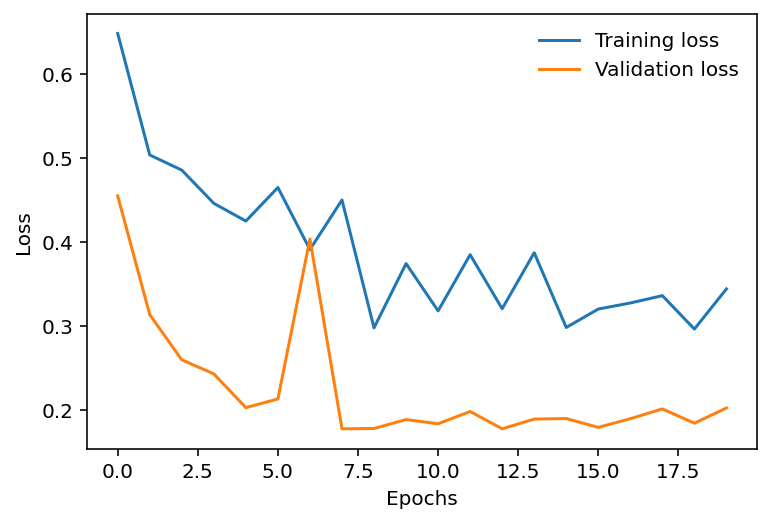

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)